# How to Analyze an Experiment that Didn't Work

## Motivation:

We want to be able to answer questions such as:

* How many times can I use this tool before it breaks?
* When are people most likely to cash in a gift card they got for Christmas?
* How many of our products will have a repair in the 2-year warranty window?

* Which members are likely to have surgery within 6-18 months?

| Member | Time to Surgery | Label |
| --- | --- | --- |
| Al | 5 months, 29 Days | False |
| Betty | 6 months, 1 Day | True |
| Charlie | 17 months 29 Days | True |
|Debroah | 18 months 1 Day | False |

* Al and Betty have very similar outcomes but are markeed as completely opposite.
* Betty and Charlie differ by almost a year, but are considered to have identical outcomes
* Charle and Deborah have very similar outcomes, but are marked as complete opposites
* Al and Deborah are the most different of all, yet have the same label

## Approach:

We are trying to predict when an event is going to happen. We start by assuming that it is a simple random event with a fixed probability of happening in any time interval or attempt.

We can model this as a die with an unknown number of sides. 
![image of dice with many sides](dice.png)
Our event happens when we roll a 1. If we roll anything else, the event does not happen.

We want to know how many times we should expect to roll it before we get a one.

This is a *Bernoulli* process with an unknown but constant probability *p* of success on each roll.

The probability of success on each roll is $$p = \frac{1}{\text{number of sides}}$$

So if we have a 40-sided die, the probability of rolling a one each time we roll it is 
$$p = \frac{1}{40} = 0.025$$

The probability of *not* getting a one is $$q = 1-p$$

Generally, we're going to need to roll it a bunch of times until we get a one.
The probability of rolling it *n* times in a row without getting a one is:

$$P(\text{not getting a one in n attempts}) = q^n$$

And the probability of getting a one on our $n^{th}$ attempt is:

$$q^{n-1}\cdot p$$
or
$$(1-p)^{n-1}\cdot p$$

This is the geometric distribution.

The Expecetation value of the geometric distribution is $1/p$ or, the average number of attempts needed to roll a 1.

So, if we want to know how many sides our die has (or how probable our event is) all we have to do is roll the die until we get a one. The number of rolls indicates the number of sides.

Unfortunately, there's a pretty wide variation in how many rolls it is likely to take to roll a one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, geom

Here we have an event that happens on average once per year, or equivalently, a die with 365 sides.

The 90th percentile confidence interval, (the range of "normal" outcomes) can vary widely:

In [2]:
np.percentile(geom(p:=1/365).rvs(10000), (5,95))

array([  20., 1107.])

Rolling this die once isn't going to work.
So, to improve our estimate of the number of sides, we repeat this experiment many times and take the average:

In [3]:
[(i,geom(p).rvs(int(i)).mean()) for i in np.logspace(1,5,5)]

[(10.0, 221.9),
 (100.0, 270.16),
 (1000.0, 358.38),
 (10000.0, 367.8288),
 (100000.0, 365.81254)]

In [29]:
np.percentile([geom(p).rvs(10000).mean() for _ in range(500)], (5, 90))

array([358.89732, 369.59905])

In [5]:
np.percentile([geom(p).rvs(100000).mean() for _ in range(500)], (5, 90))

array([363.134941, 366.511884])

#### This is the very best way to get a good estimate of the probability of the event.

The problem is it can take a lot of time and resources.

To get this estimate, we had to roll the die 36 million times.

In [6]:
geom(p).rvs(100000).sum()

36632226

In [7]:
geom(p).rvs(100000).max()

4704

## How can we get the same quality of estimate with many fewer rolls?

## What if we are constrained in how many rolls we can attempt?

### Suppose we have a 40-sided die, but we are limited to only rolling each die 30 times.

#### This means a lot of our trials will end without ever rolling a one. 

In [31]:
n = 40
k = 30
rolls = geom(1/n).rvs(1000)
observations = np.where(rolls<=k, rolls, np.nan)
observations

array([nan, 12.,  4., nan, nan, nan, 21.,  4., 21., 10.,  4.,  2.,  7.,
       25., nan, 17.,  7., 20., 23.,  4., nan, nan, nan, nan,  4.,  6.,
       13., nan, 16., nan, nan, nan,  8., nan, nan, 19., nan,  6., nan,
        1., nan, nan, 12., nan, 20.,  3., nan, nan, nan, 14., 27.,  5.,
       27., 23.,  8., 25., nan, nan, nan, 27., nan, 12., nan, nan, nan,
       21., 12.,  2., nan, nan, nan, 19., nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan,  5., nan, nan, 11.,  1.,  2.,  2., 28., nan,
       23., 27., nan, 29., 18., 16., nan, 22., 10., 21.,  7., nan,  4.,
       nan, nan, nan, nan, 29., 22., nan,  2., nan, nan, nan, 21.,  2.,
        4.,  7., nan, nan, nan, nan, nan,  4., nan, nan, 16., nan, nan,
       nan, 13., nan,  3.,  2., 27., 15., 27., nan,  5., nan, nan,  8.,
        6., nan, nan, 28., 18., 13., 19., 19., nan, 15., nan, nan, 23.,
       nan,  8.,  2., 24., 26., nan, nan, 22., 12.,  4.,  2., nan, 25.,
       nan,  4., nan, 29.,  3., nan, nan, nan, nan, 12., nan, na

In [36]:
np.nansum(observations) + k*np.isnan(observations).sum()

21552.0

## How should we record these results?

* Ignore them. If we never observed a result, we can't use that trial
* Assume they would have produced a one on the next roll $t=k+1$
* Assume they would produce a one at $t=\infty$
* Fill in missing values with the mean of observed values
* Assume success at $t=2k$
* Something else

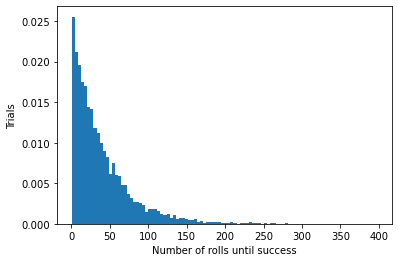

In [9]:
y,x,_= plt.hist(rolls:=geom(1/40).rvs(10000), bins=100, density=True)
plt.xlabel('Number of rolls until success')
plt.ylabel('Trials');

### What we want to do is replace all of the values on the right side of the line with a single value at the average of the orange region.

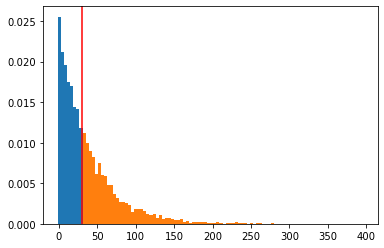

In [10]:
x = x[:(len(y))]
plt.bar(x[x<=k],y[x<=k], width=x[1]-x[0])
plt.bar(x[x>k],y[x>k], width=x[1]-x[0])
plt.axvline(k, color = 'red');

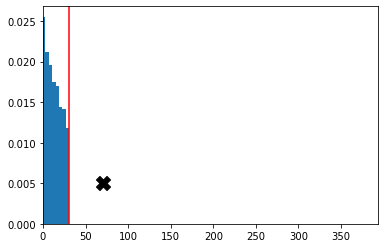

In [11]:
plt.bar(x[x<=k],y[x<=k], width=x[1]-x[0])
plt.axvline(k, color = 'red')
plt.xlim((0,x.max()))
plt.scatter(k + 1/(1-((rolls>=k).mean())**(1/k)), .005, s=200, marker = 'X', color='black');

## Memorylessness:

#### No matter how long you have been waiting, you can expect to keep waiting

When you first start rolling a die, you can expect to get a one in $N$ rolls.

If you have already rolled it 10 times, you can expect to get a one in $N$ *more* rolls.

If you have already rolled it $k$ times, your can expect to roll a one at $t=k+N$

Unfortunately, we don't know $N$. That's what we're trying to figure out.

We can get an estimate of $N$ from the cumulative distribution function of the geometric distribution:

$$\text {cdf}(k) = 1-(1-p)^k$$


Where $k$ is the threshold or timeout value.
$cdf(k)$ is the number of trials that result in success at or before $k$ rolls.
And, of course, $p=\frac{1}{N}$.

Rearrange:
$$N = \frac{1}{1-(1-\text{cdf}(k))^{\frac{1}{k}}}$$


## Procedure:

1. Roll the die until either you get a 1 or reach the timeout limit
2. If you get a 1, record the actual number of rolls
3. If you don't get a 1, record a temporary variable (Λ)
4. When you are done with all the trials, calculate how many ended in success: (*cdf(k)*)
5. Calculate $N$ from the equation above.
6. Replace all Λ with $Λ = k + N$
7. Take the average of all values, observed and imputed, $\bar x$
8. The probability is: $p = \frac {1}{\bar x}$

In [12]:
observations

array([ 5.,  4., 15., ..., nan, 13., 27.])

In [13]:
cdf = 1- np.isnan(observations).mean()
cdf

0.5326

In [14]:
N = 1/(1-(1-cdf)**(1/k))
N

39.94622122860819

In [15]:
Λ = k + N
Λ

69.94622122860818

In [16]:
x = np.where(np.isnan(observations), Λ, observations)
x

array([ 5.        ,  4.        , 15.        , ..., 69.94622123,
       13.        , 27.        ])

In [17]:
x.mean(), n

(39.98876380225146, 40)

# Part 2

What if the timeout value ($k$) is not the same for each observation?

In [18]:
n_samples = 1000
df = pd.DataFrame()
ks = np.random.randint(15, 60, n_samples)
ds = geom(1/n).rvs(n_samples)
df['observation'] = np.where(ds<=ks, ds, np.nan)
df['timeout'] = np.where(ds<ks, ds, ks)
df['success'] = ~df['observation'].isna()
df

,observation,timeout,success
0,16.0,16,True
1,NaN,56,False
2,17.0,17,True
3,29.0,29,True
4,2.0,2,True
...,...,...,...
995,3.0,3,True
996,43.0,43,True
997,NaN,45,False
998,NaN,16,False


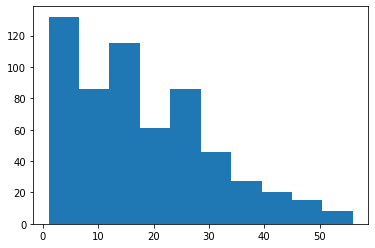

In [19]:
plt.hist(df['observation']);

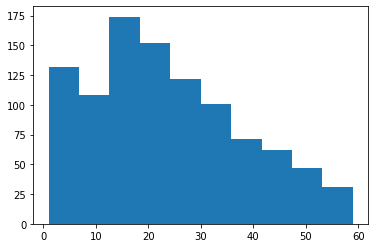

In [20]:
plt.hist(df['timeout']);

In [21]:
success_profile = {k:df[df['timeout']<=k]['success'].sum()/n_samples for k in df['timeout'].unique()}

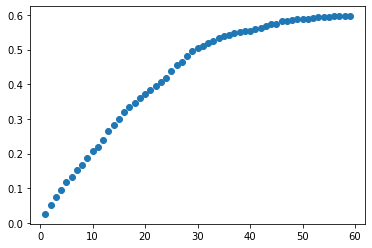

In [22]:
v = np.array([i for i in success_profile.values()])
plt.scatter(success_profile.keys(), v)

In [23]:
S = pd.DataFrame(index = success_profile.keys(), 
                 data = success_profile.values(), columns=['S'])
S.index.name='timeout'
df = df.set_index('timeout').join(S).reset_index()#.rename({'index':'timeout'})
df['S'] = np.where(df['observation'].isna(), df['S'], np.nan)

In [24]:
df['Λ'] =df['timeout'] + 1/(1-(1-df['S'])**(1/df['timeout']))
df

,timeout,observation,success,S,Λ
0,1,1.0,True,NaN,NaN
1,1,1.0,True,NaN,NaN
2,1,1.0,True,NaN,NaN
3,1,1.0,True,NaN,NaN
4,1,1.0,True,NaN,NaN
...,...,...,...,...,...
995,58,NaN,False,0.596,122.494919
996,58,NaN,False,0.596,122.494919
997,58,NaN,False,0.596,122.494919
998,58,NaN,False,0.596,122.494919


In [25]:
df['x'] = np.where(df['success'], df['observation'], df['Λ'])
df

,timeout,observation,success,S,Λ,x
0,1,1.0,True,NaN,NaN,1.000000
1,1,1.0,True,NaN,NaN,1.000000
2,1,1.0,True,NaN,NaN,1.000000
3,1,1.0,True,NaN,NaN,1.000000
4,1,1.0,True,NaN,NaN,1.000000
...,...,...,...,...,...,...
995,58,NaN,False,0.596,122.494919,122.494919
996,58,NaN,False,0.596,122.494919,122.494919
997,58,NaN,False,0.596,122.494919,122.494919
998,58,NaN,False,0.596,122.494919,122.494919


In [26]:
df['x'].mean()

42.83668487210049

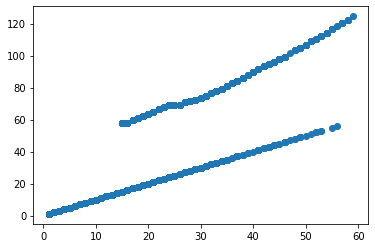

In [27]:
plt.scatter(df['timeout'],df['x']);